In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:{}".format(device))
data_dir = './Garbage classification/Garbage classification'  # 数据所在目录

Using device:cuda:0


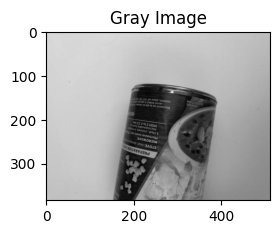

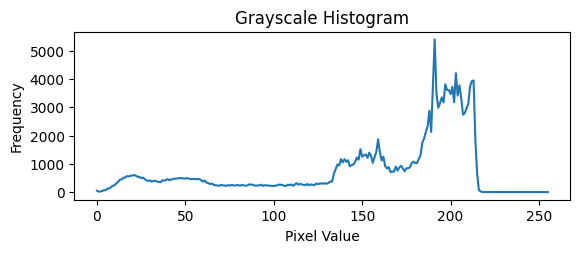

In [2]:
from matplotlib import pyplot as plt
import cv2

example = './Garbage classification/Garbage classification/metal/metal66.jpg'


def plot_gray_image(img_path):
    """绘制灰度及其直方图"""
    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 灰度加载
    # 绘制灰度图像
    plt.subplot(2, 1, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Gray Image')
    plt.show()
    # 绘制灰度直方图
    plt.subplot(2, 1, 2)
    hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.title('Grayscale Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # 显示图像及直方图
    plt.show()


plot_gray_image(example)

数据分布

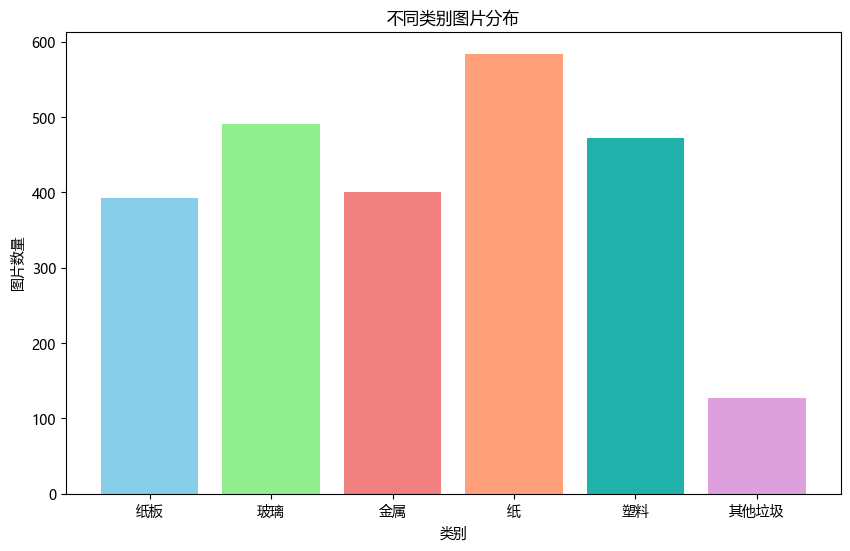

In [3]:
# 中文绘制
plt.rcParams['font.family'] = 'Microsoft YaHei'

categories = ['纸板', '玻璃', '金属', '纸', '塑料', '其他垃圾']
counts = [393, 491, 400, 584, 472, 127]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen', 'plum']

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.xlabel('类别')
plt.ylabel('图片数量')
plt.title('不同类别图片分布')
plt.show()

In [4]:
# from torchvision import transforms

# transform
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     # 随机图像亮度、对比度、饱和度
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     # 随机翻转
#     transforms.RandomHorizontalFlip(),
#     # 随机放射变化
#     transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 归一化
# ])

In [5]:
# from torchvision.datasets import ImageFolder
#
# bs = 16  # batch_size
#
# dataset = ImageFolder(data_dir, transform=transform)
# dataset

In [6]:
import torchvision.transforms as transform

transformer = {
    'original': transform.Compose([
        transform.Resize((224, 224)),
        transform.ToTensor(),
        transform.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'dataset1': transform.Compose([
        transform.Resize((224, 224)),
        #随机图像亮度、对比度、饱和度
        transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        #随机翻转
        transform.RandomRotation(5),
        #随机放射变化
        transform.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
        transform.ToTensor(),
        transform.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}

In [7]:
from torch.utils.data import ConcatDataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

bs = 16

original = ImageFolder(data_dir, transform=transformer['original'])

#all_set = train_val + test
train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

#train_val = train + val + dataset1 + dataset2 + dataset3
train_val = ConcatDataset([train_val,
                           ImageFolder(data_dir, transform=transformer['dataset1'])])

train, val = train_test_split(train_val, test_size=0.1, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=True),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=True),
    'test': DataLoader(test, batch_size=bs, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test),
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


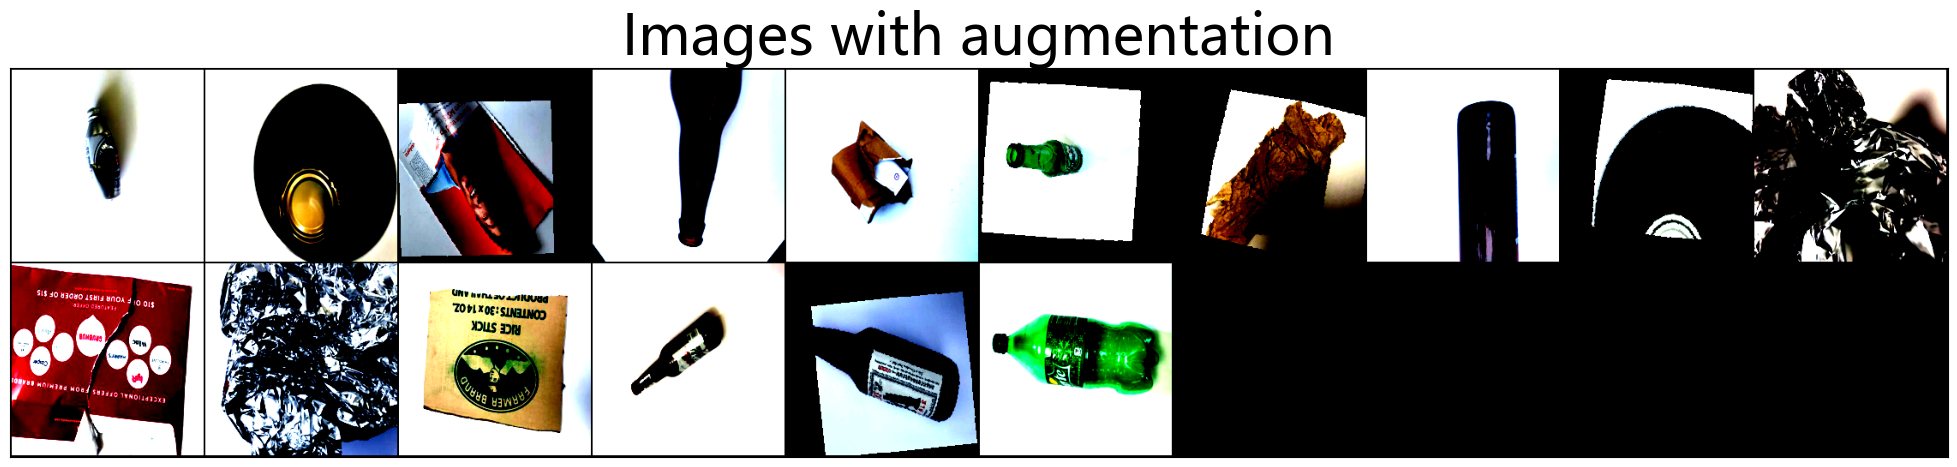

In [8]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break


show_batch(loaders['train'])

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.Tensor(preds == labels)).item() / len(preds)), preds


#save the losses for further visualization
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}
lr = []

In [10]:
import torchvision
import torch.nn as nn

densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
    param.requires_grad = False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features,
                                     out_features=len(original.classes), bias=True)

X:\Coding\Github\LearnDeepWithPyTorch\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
X:\Coding\Github\LearnDeepWithPyTorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
convnext = torchvision.models.convnext_tiny(pretrained=True)
for param in convnext.parameters():
    param.grad_requires = False
convnext.classifier[2] = nn.Linear(in_features=768, out_features=6, bias=True)

X:\Coding\Github\LearnDeepWithPyTorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
    param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(original.classes), bias=True)

X:\Coding\Github\LearnDeepWithPyTorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import time
import copy


def train(seed, epochs, model):
    print('Creating a model {}...'.format(seed))

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    if seed == 2:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
    else:
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,
                                     weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(torch.Tensor(pred == labels.data))

            if phase == 'train':
                acc = 100. * running_corrects.double() / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch + 1, epochs))
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)

            if phase == 'val':
                print('Time: {}m {}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
                print('==' * 31)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
        #scheduler.step()
    time_elapsed = time.time() - since
    print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)

    model.load_state_dict(best_model)

    for param in model.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #             lr.append(scheduler.get_lr())
                #             scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(torch.Tensor(pred == labels.data))

            if phase == 'train':
                acc = 100. * running_corrects.double() / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch + 1, epochs))
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)

            if phase == 'val':
                print('Time: {}m {}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
                print('==' * 31)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
        #scheduler.step()
    time_elapsed = time.time() - since
    print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)

    model.load_state_dict(best_model)
    return model

In [16]:
num_models = 3
epochs = 10

models = [convnext, densenet121_0, resnet101]

# for seed in range(num_models):
#     print(seed)
#     train(seed=seed, epochs=epochs, model=models[seed])
model = train(seed=0, epochs=epochs, model=models[0])
model

Creating a model 0...
Epoch: 1/10
train - loss:0.3214447473455926, accuracy0.8986073784510139
val - loss:0.2643168395426083, accuracy0.9142857142857143
Time: 1.0m 17.72549557685852s
Epoch: 2/10
train - loss:0.24136902619814948, accuracy0.9262154898607379
val - loss:0.23302931344177533, accuracy0.9142857142857143
Time: 2.0m 35.55103778839111s
Epoch: 3/10
train - loss:0.20184087316054397, accuracy0.9357439530906426
val - loss:0.21297873807354614, accuracy0.9274725274725275
Time: 3.0m 54.05000329017639s
Epoch: 4/10
train - loss:0.16606752919212928, accuracy0.9501588077204984
val - loss:0.1961419169632411, accuracy0.9296703296703297
Time: 5.0m 12.262603759765625s
Epoch: 5/10
train - loss:0.14180332791781966, accuracy0.95699975568043
val - loss:0.19255197210094102, accuracy0.9362637362637363
Time: 6.0m 30.563023328781128s
Epoch: 6/10
train - loss:0.1291912945081618, accuracy0.9628634253603714
val - loss:0.19121395583024023, accuracy0.9340659340659341
Time: 7.0m 49.26547122001648s
Epoch: 7/1

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [3]:
torch.save(model, 'convnext.pth')

NameError: name 'torch' is not defined